In [1]:
import jax
import jax.numpy as jnp
import optax

import matplotlib.pyplot as plt
import jax.random as random
import tensorflow_probability.substrates.jax as tfp

In [2]:
X = random.multivariate_normal(
    key=random.PRNGKey(0),
    shape=(100,),
    mean=jnp.array([1, 3]),
    cov=jnp.array([[1.0, -0.5], [-0.5, 2.0]]),
)

In [3]:
X.shape

(100, 2)

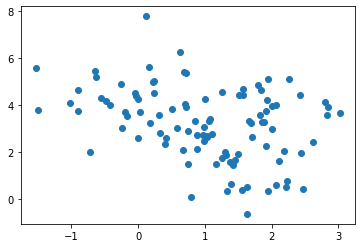

In [4]:
plt.scatter(X[:, 0], X[:, 1])
#plt.gca().set_aspect("equal")

In [5]:
from flax import linen as nn
from typing import Any, Callable, Sequence


In [6]:
class Encoder(nn.Module):
    bottleneck: int
        
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(5)(x)
        x = nn.selu(x)
        x = nn.Dense(features=self.bottleneck)(x)
        return x

In [7]:
class Decoder(nn.Module): 
    out: int
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(5)(x)
        x = nn.selu(x)
        x = nn.Dense(features=self.out)(x)
        return x

In [8]:
enc = Encoder(bottleneck=1)

dec = Decoder(out=2)

In [9]:
params_enc = enc.init(random.PRNGKey(0), X)
X_bottlenecked = enc.apply(params_enc, X)
X_bottlenecked.shape

(100, 1)

In [10]:
print(enc.tabulate(random.PRNGKey(0), X))

print(dec.tabulate(random.PRNGKey(0), X_bottlenecked))


                               Encoder Summary                                
┏━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module  ┃ inputs         ┃ outputs        ┃ params               ┃
┡━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│         │ Encoder │ float32[100,2] │ float32[100,1] │                      │
├─────────┼─────────┼────────────────┼────────────────┼──────────────────────┤
│ Dense_0 │ Dense   │ float32[100,2] │ float32[100,5] │ bias: float32[5]     │
│         │         │                │                │ kernel: float32[2,5] │
│         │         │                │                │                      │
│         │         │                │                │ 15 (60 B)            │
├─────────┼─────────┼────────────────┼────────────────┼──────────────────────┤
│ Dense_1 │ Dense   │ float32[100,5] │ float32[100,1] │ bias: float32[1]     │
│         │         │                │             

In [11]:
class AE(nn.Module):
    bottleneck: int
    out: int
    kind: str = "regular"
    def setup(self):
        # Alternative to @nn.compact -> explicitly define modules
        # Better for later when we want to access the encoder and decoder explicitly
        self.encoder = Encoder(bottleneck=self.bottleneck)
        self.decoder = Decoder(out=self.out)

    def __call__(self, x):
        
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    

In [12]:
ae = AE(1, 2)

In [13]:
ae

AE(
    # attributes
    bottleneck = 1
    out = 2
    kind = 'regular'
)

In [14]:
print(ae.tabulate(random.PRNGKey(0), X))



                                   AE Summary                                   
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path            ┃ module  ┃ inputs         ┃ outputs        ┃ params         ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│                 │ AE      │ float32[100,2] │ float32[100,2] │                │
├─────────────────┼─────────┼────────────────┼────────────────┼────────────────┤
│ encoder         │ Encoder │ float32[100,2] │ float32[100,1] │                │
├─────────────────┼─────────┼────────────────┼────────────────┼────────────────┤
│ encoder/Dense_0 │ Dense   │ float32[100,2] │ float32[100,5] │ bias:          │
│                 │         │                │                │ float32[5]     │
│                 │         │                │                │ kernel:        │
│                 │         │                │                │ float32[2,5]   │
│                 │        

In [15]:
params = ae.init(random.PRNGKey(0), X)
params

FrozenDict({
    params: {
        encoder: {
            Dense_0: {
                kernel: DeviceArray([[ 0.17535934, -1.0953957 ,  0.69273657, -0.26352578,
                               0.63077825],
                             [ 0.36360174, -0.73782593, -0.5395247 , -0.41536337,
                              -0.30090812]], dtype=float32),
                bias: DeviceArray([0., 0., 0., 0., 0.], dtype=float32),
            },
            Dense_1: {
                kernel: DeviceArray([[-0.64744544],
                             [ 0.4855265 ],
                             [-0.82133824],
                             [ 0.62454295],
                             [ 0.6013553 ]], dtype=float32),
                bias: DeviceArray([0.], dtype=float32),
            },
        },
        decoder: {
            Dense_0: {
                kernel: DeviceArray([[-0.5305567 ,  1.1100855 , -0.31129056,  0.43152457,
                              -0.09589562]], dtype=float32),
                bias: De

In [16]:
X_hat = ae.apply(params, X)
X_hat.shape

(100, 2)

In [17]:
encoded_1d = Encoder(1).apply({"params":params["params"]["encoder"]}, X).flatten()
encoded_1d

DeviceArray([-2.4718695, -2.1964366, -2.6823573, -2.4936142, -1.7122931,
             -1.8346143, -2.0767107, -1.8570523, -1.7632042, -2.0679352,
             -2.2317708, -2.14561  , -1.0023857, -2.1458385, -2.3645976,
             -1.9418356, -2.7020268, -1.6407721, -1.8281609, -2.2202983,
             -2.5174992, -2.5888596, -2.0095935, -2.4470627, -2.18571  ,
             -1.9742886, -1.8921608, -2.245328 , -0.8897901, -2.5329058,
             -2.2861118, -1.5862434, -2.2295656, -2.4962962, -2.4043853,
             -2.0180438, -1.8416758, -1.858724 , -2.0980942, -1.7771733,
             -2.0027542, -2.1870096, -2.44952  , -1.7563679, -1.5761943,
             -2.3097022, -2.0295165, -2.9528205, -2.2042172, -1.9090191,
             -1.8868417, -2.4206855, -2.143362 , -1.8804221, -2.5127394,
             -2.1454868, -2.0043783, -2.5703878, -2.5082104, -2.3339696,
             -1.8621875, -2.4201615, -2.5613968, -2.0498512, -1.6772006,
             -1.6392376, -2.385527 , -1.8138398, -3

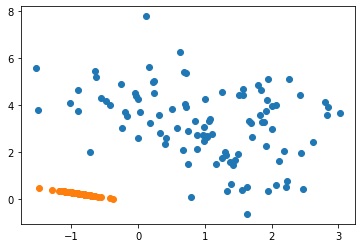

In [18]:
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(X_hat[:, 0], X_hat[:, 1])


In [19]:
diff = X - X_hat

In [20]:
diff.shape

(100, 2)

In [21]:
diff[:5]

DeviceArray([[-0.46981597,  5.271835  ],
             [ 1.6502907 ,  3.6781619 ],
             [ 1.8507848 ,  5.0589485 ],
             [ 2.8690844 ,  4.5646677 ],
             [ 0.4905889 ,  2.8893168 ]], dtype=float32)

In [22]:
(diff**2).sum(axis=1).mean()/2

DeviceArray(7.9555407, dtype=float32)

In [23]:
(diff**2).sum(axis=1)[:5]

DeviceArray([28.01297 , 16.252335, 29.018364, 29.067837,  8.588829], dtype=float32)

In [24]:
(jnp.linalg.norm(diff, ord=2, axis=1)**2).mean()/2

DeviceArray(7.955541, dtype=float32)

In [25]:
from sklearn.metrics import mean_squared_error

In [26]:
mean_squared_error(X, X_hat)

7.9555407

In [27]:
2*optax.l2_loss(X_hat, X).mean()

DeviceArray(7.9555426, dtype=float32)

In [28]:
@jax.jit
def loss(params, X):
    X_hat = ae.apply(params, X)
    diff = X - X_hat
    return (diff**2).sum(axis=1).mean()/X.shape[1]

In [29]:
loss(params, X)

DeviceArray(7.9555426, dtype=float32)

In [30]:
learning_rate = 0.01
tx = optax.adam(learning_rate=learning_rate)
opt_state = tx.init(params)
loss_grad_fn = jax.value_and_grad(loss)

In [31]:
loss_grad_fn = jax.value_and_grad(loss)

In [32]:
for i in range(501):
    loss_val, grads = loss_grad_fn(params, X)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 10 == 0:
        print('Loss step {}: '.format(i), loss_val)

Loss step 0:  7.9555426
Loss step 10:  4.371923
Loss step 20:  2.0022397
Loss step 30:  0.8814581
Loss step 40:  0.6169854
Loss step 50:  0.58760303
Loss step 60:  0.50901914
Loss step 70:  0.45536247
Loss step 80:  0.432769
Loss step 90:  0.4182511
Loss step 100:  0.41105446
Loss step 110:  0.40823323
Loss step 120:  0.40664482
Loss step 130:  0.40552917
Loss step 140:  0.40466255
Loss step 150:  0.40397438
Loss step 160:  0.403377
Loss step 170:  0.4028761
Loss step 180:  0.40248054
Loss step 190:  0.4021578
Loss step 200:  0.40188238
Loss step 210:  0.40164244
Loss step 220:  0.40143713
Loss step 230:  0.4012555
Loss step 240:  0.40107086
Loss step 250:  0.40089256
Loss step 260:  0.40072623
Loss step 270:  0.40056506
Loss step 280:  0.40040958
Loss step 290:  0.40026754
Loss step 300:  0.4001389
Loss step 310:  0.4000205
Loss step 320:  0.39990643
Loss step 330:  0.399792
Loss step 340:  0.3996803
Loss step 350:  0.399571
Loss step 360:  0.3994619
Loss step 370:  0.39935783
Loss st

In [33]:
X_hat = ae.apply(params, X)

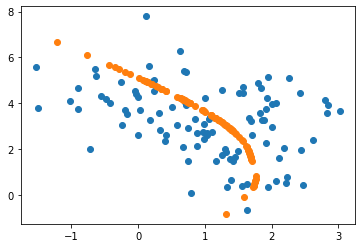

In [34]:
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(X_hat[:, 0], X_hat[:, 1])

In [35]:
Encoder(1).apply({"params":params["params"]["encoder"]}, X)[:5]

DeviceArray([[-6.7409124],
             [-3.796666 ],
             [-5.1738505],
             [-4.0559273],
             [-3.3746643]], dtype=float32)

In [36]:
from sklearn import datasets

In [37]:
digits = datasets.load_digits()

In [38]:
X = jnp.array(digits['data'])
y = digits["target"]

In [39]:
X.shape

(1797, 64)

1

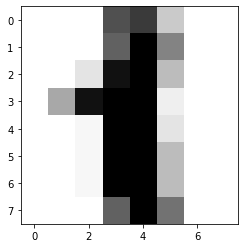

In [40]:
plt.imshow(X[1].reshape(8, 8), cmap='Greys')
y[1]

In [41]:
bn = 8
ae = AE(bn, X.shape[1])

ae

AE(
    # attributes
    bottleneck = 8
    out = 64
    kind = 'regular'
)

In [42]:
print(ae.tabulate(random.PRNGKey(0), X))



                                   AE Summary                                   
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path           ┃ module  ┃ inputs         ┃ outputs         ┃ params         ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│                │ AE      │ float32[1797,… │ float32[1797,6… │                │
├────────────────┼─────────┼────────────────┼─────────────────┼────────────────┤
│ encoder        │ Encoder │ float32[1797,… │ float32[1797,8] │                │
├────────────────┼─────────┼────────────────┼─────────────────┼────────────────┤
│ encoder/Dense… │ Dense   │ float32[1797,… │ float32[1797,5] │ bias:          │
│                │         │                │                 │ float32[5]     │
│                │         │                │                 │ kernel:        │
│                │         │                │                 │ float32[64,5]  │
│                │         

In [43]:
params = ae.init(random.PRNGKey(0), X)

In [44]:
jax.tree_util.tree_map(lambda x: x.shape, params)

FrozenDict({
    params: {
        decoder: {
            Dense_0: {
                bias: (5,),
                kernel: (8, 5),
            },
            Dense_1: {
                bias: (64,),
                kernel: (5, 64),
            },
        },
        encoder: {
            Dense_0: {
                bias: (5,),
                kernel: (64, 5),
            },
            Dense_1: {
                bias: (8,),
                kernel: (5, 8),
            },
        },
    },
})

In [45]:
import seaborn as sns
import pandas as pd
def plot_encoding_2dim(encoder, params):
    assert encoder.bottleneck >= 2
    X_low = encoder.apply({"params":params["params"]["encoder"]}, X)
    df = pd.DataFrame(X_low)
    df["label"] = y
    sns.pairplot(df, hue="label", palette="bright")

In [46]:
tx = optax.adam(learning_rate=1e-2)
params = ae.init(random.PRNGKey(0), X)
opt_state = tx.init(params)

### Untrained encodings

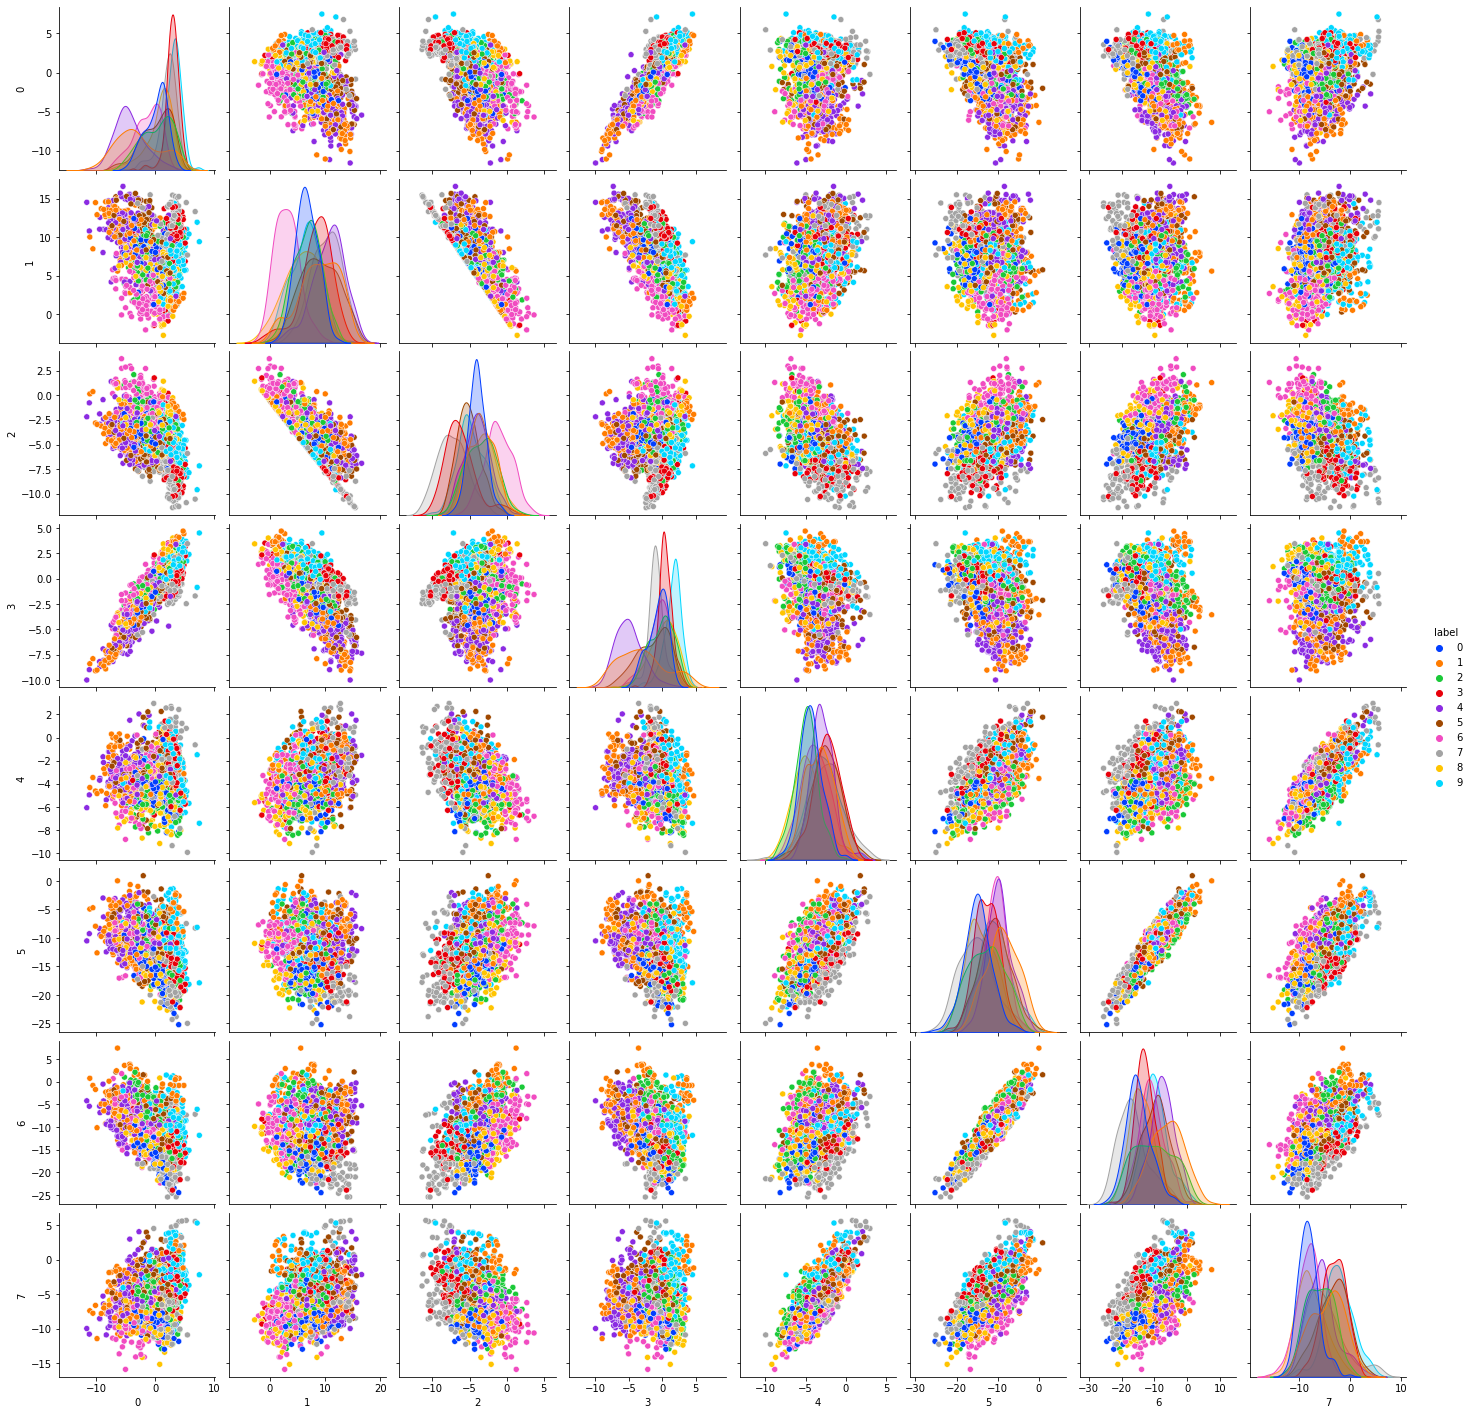

In [47]:
plot_encoding_2dim(Encoder(bottleneck=bn), params)

In [48]:
X_recon = ae.apply(params, X)

In [49]:
def plot_orig_recon(index=0):
    fig, ax = plt.subplots(sharex=True, ncols=2)
    ax[0].imshow(X[index].reshape(8, 8), cmap='Greys')
    ax[1].imshow(X_recon[index].reshape(8, 8), cmap='Greys')
    ax[0].set_title("Original")
    ax[1].set_title("Reconstructed")
    


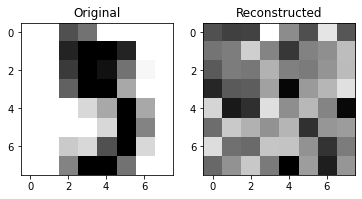

In [50]:
plot_orig_recon(5)

In [51]:
for i in range(2000):
    loss_val, grads = loss_grad_fn(params, X)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 100 == 0:
        print('Loss step {}: '.format(i), loss_val)

Loss step 0:  152.57704
Loss step 100:  23.991776
Loss step 200:  19.028137
Loss step 300:  18.77819
Loss step 400:  18.720373
Loss step 500:  18.577263
Loss step 600:  18.315
Loss step 700:  17.905659
Loss step 800:  17.392805
Loss step 900:  16.894617
Loss step 1000:  16.552359
Loss step 1100:  16.355219
Loss step 1200:  16.233782
Loss step 1300:  16.160349
Loss step 1400:  16.1181
Loss step 1500:  16.09204
Loss step 1600:  16.074528
Loss step 1700:  16.062346
Loss step 1800:  16.053143
Loss step 1900:  16.046421


### Trained encodings

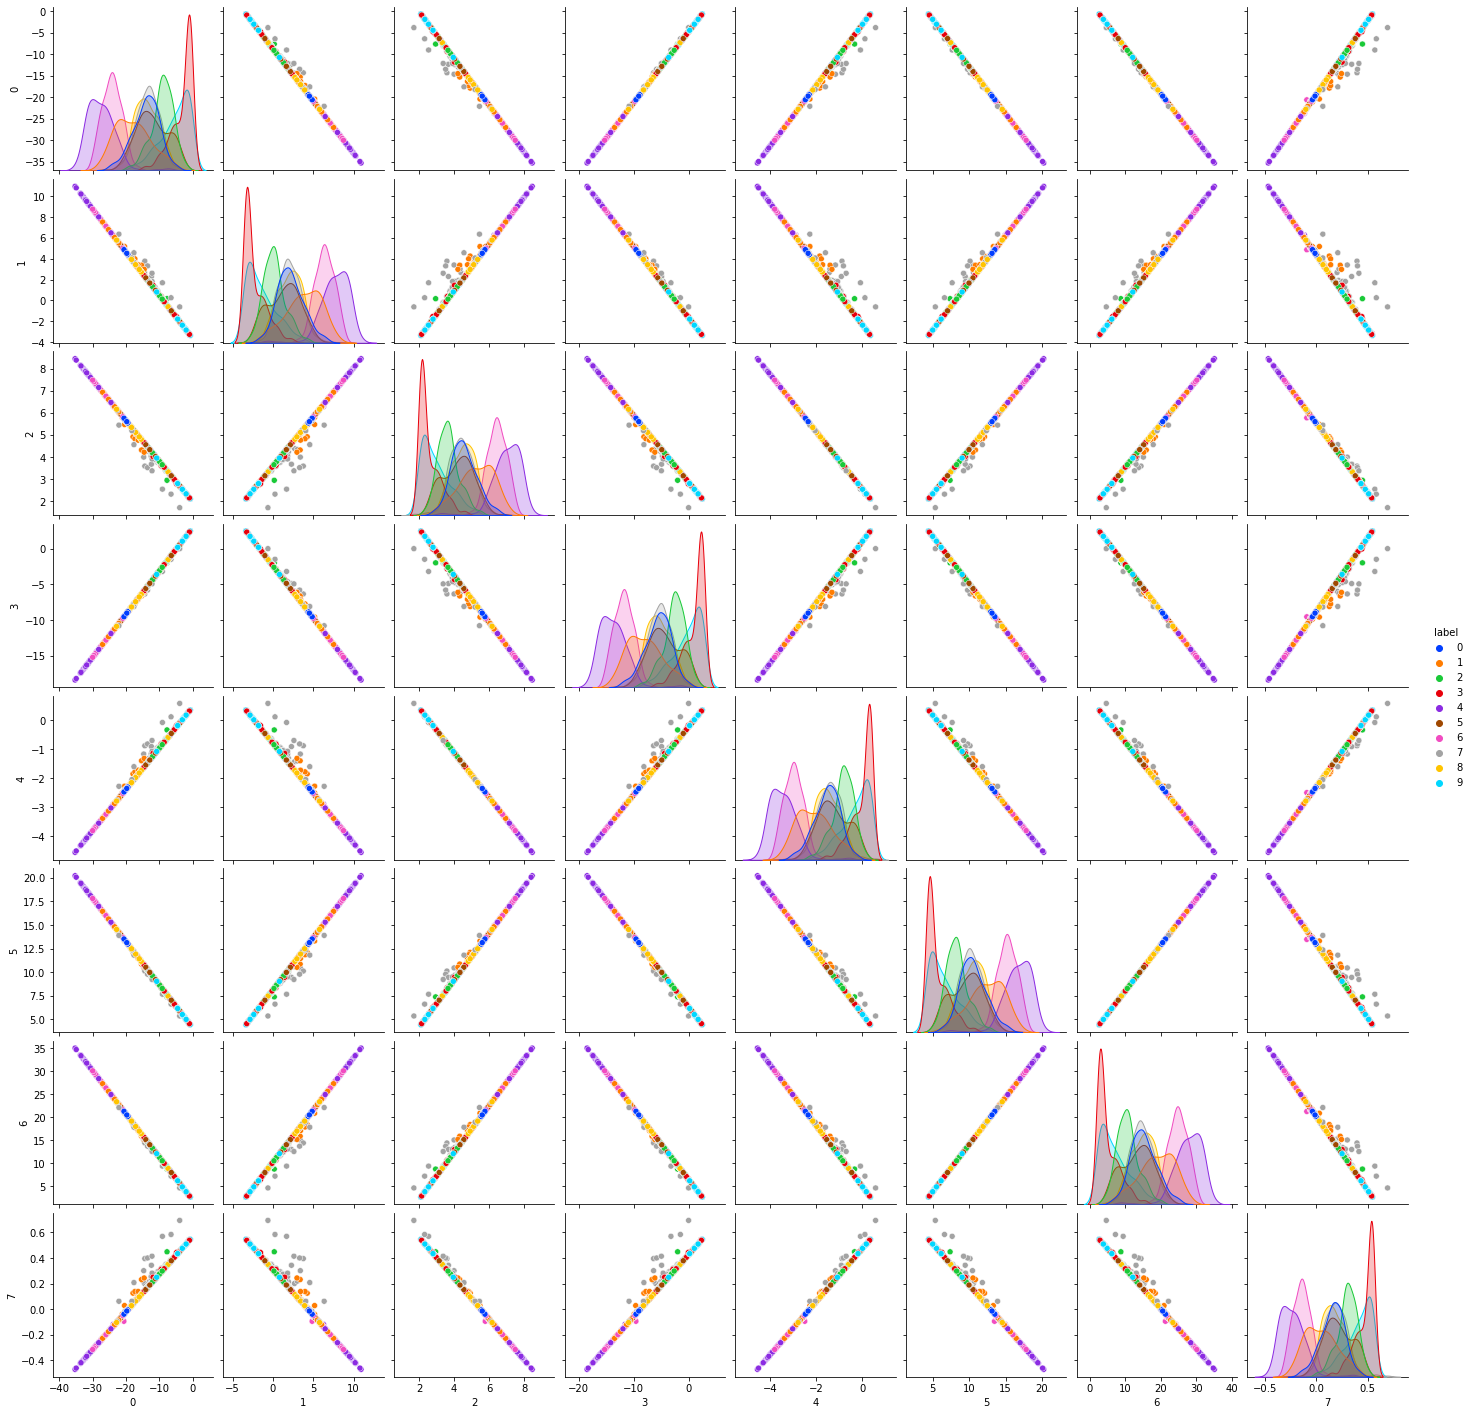

In [52]:
plot_encoding_2dim(Encoder(bottleneck=bn), params)

### Reconstruction

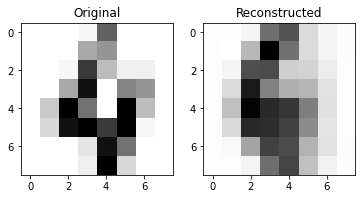

In [53]:
X_recon = ae.apply(params, X)
plot_orig_recon(4)

In [54]:
X_reconstructed = ae.apply(params, X)

In [55]:
errs = jnp.square(X - X_reconstructed).sum(axis=1)
err_df = pd.DataFrame({"error":errs, "label":y})
err_df.groupby("label").mean()

,error
label,
0,1067.152466
1,1253.274414
2,1187.444946
3,730.805969
4,919.766541
5,1103.431396
6,913.187927
7,1309.414062
8,892.937744


In [56]:
err_df = pd.DataFrame({"error":errs, "label":y})

In [57]:
err_df.groupby("label").mean()

,error
label,
0,1067.152466
1,1253.274414
2,1187.444946
3,730.805969
4,919.766541
5,1103.431396
6,913.187927
7,1309.414062
8,892.937744


### Convoluational AE

In [135]:
class ConvEncoder(nn.Module):
    bottleneck: int    
    @nn.compact
    def __call__(self, x):
        n = x.shape[0] # x is nx64
        x = x.reshape(n, 8, 8, 1)
        x = nn.Conv(features=4, kernel_size=(2, 2), strides=1, padding=0)(x) # 8X8X1 -> 6x6X4
        x = nn.selu(x)
        x = nn.max_pool(x, window_shape=(2,2), strides=(2, 2))  # 6x6x4 --> 3x3x4
        x = nn.selu(x)
        x = x.reshape(n, -1) #N X 3x3x4 -> N X 36
        x = nn.Dense(self.bottleneck)(x)
        return x

In [167]:
ce = ConvEncoder(2)
print(ce.tabulate(random.PRNGKey(0), X))
print(ce.tabulate(random.PRNGKey(0), X, console_kwargs={"width":120}))


                              ConvEncoder Summary                               
┏━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module      ┃ inputs          ┃ outputs         ┃ params           ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│         │ ConvEncoder │ float32[1797,6… │ float32[1797,2] │                  │
├─────────┼─────────────┼─────────────────┼─────────────────┼──────────────────┤
│ Conv_0  │ Conv        │ float32[1797,8… │ float32[1797,7… │ bias: float32[4] │
│         │             │                 │                 │ kernel:          │
│         │             │                 │                 │ float32[2,2,1,4] │
│         │             │                 │                 │                  │
│         │             │                 │                 │ 20 (80 B)        │
├─────────┼─────────────┼─────────────────┼─────────────────┼──────────────────┤
│ Dense_0 │ Dense       │ f


                                      ConvEncoder Summary                                       
┏━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path    ┃ module      ┃ inputs              ┃ outputs             ┃ params                   ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         │ ConvEncoder │ float32[1797,64]    │ float32[1797,2]     │                          │
├─────────┼─────────────┼─────────────────────┼─────────────────────┼──────────────────────────┤
│ Conv_0  │ Conv        │ float32[1797,8,8,1] │ float32[1797,7,7,4] │ bias: float32[4]         │
│         │             │                     │                     │ kernel: float32[2,2,1,4] │
│         │             │                     │                     │                          │
│         │             │                     │                     │ 20 (80 B)                │
├─────────┼─────────────┼────

In [141]:
class ConvDecoder(nn.Module):
        
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(36)(x) # Nx2 --> Nx36
        x = nn.selu(x)
        x = x.reshape(-1, 3, 3, 4) # NX3X3X4
        x = nn.ConvTranspose(features=4, kernel_size=(2, 2), strides=(2, 2))(x) # 3x3x4 -> 6x6X4
        x = nn.selu(x)
        x = nn.Conv(features=1, kernel_size=(1, 1), strides=1, padding=1)(x) # 6x6x4 -> 8x8x1
        x = x.reshape(-1, 64)
        return x

In [142]:
cd = ConvDecoder()
print(cd.tabulate(
    random.PRNGKey(0),
    jax.random.normal(key=jax.random.PRNGKey(0), shape=(1, 2)),
    console_kwargs={"width": 120},
))


                                        ConvDecoder Summary                                         
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path            ┃ module        ┃ inputs           ┃ outputs          ┃ params                   ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                 │ ConvDecoder   │ float32[1,2]     │ float32[1,64]    │                          │
├─────────────────┼───────────────┼──────────────────┼──────────────────┼──────────────────────────┤
│ Dense_0         │ Dense         │ float32[1,2]     │ float32[1,36]    │ bias: float32[36]        │
│                 │               │                  │                  │ kernel: float32[2,36]    │
│                 │               │                  │                  │                          │
│                 │               │                  │                  │ 108 (432 B)     

In [143]:
class ConvAE(nn.Module):
    bottleneck: int
    def setup(self):
        # Alternative to @nn.compact -> explicitly define modules
        # Better for later when we want to access the encoder and decoder explicitly
        self.encoder = ConvEncoder(bottleneck=self.bottleneck)
        self.decoder = ConvDecoder()

    def __call__(self, x):
        
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat
    

In [145]:
cae = ConvAE(2)
print(cae.tabulate(
    random.PRNGKey(0),
    X,
    console_kwargs={"width": 120},
))


                                                  ConvAE Summary                                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path                    ┃ module        ┃ inputs              ┃ outputs             ┃ params                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                         │ ConvAE        │ float32[1797,64]    │ float32[1797,64]    │                          │
├─────────────────────────┼───────────────┼─────────────────────┼─────────────────────┼──────────────────────────┤
│ encoder                 │ ConvEncoder   │ float32[1797,64]    │ float32[1797,2]     │                          │
├─────────────────────────┼───────────────┼─────────────────────┼─────────────────────┼──────────────────────────┤
│ encoder/Conv_0          │ Conv          │ float32[1797,8,8,1] │ float32[1797,

In [156]:
params = cae.init(random.PRNGKey(0), X)

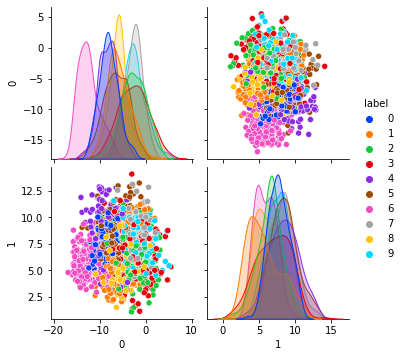

In [157]:
plot_encoding_2dim(ConvEncoder(bottleneck=2), params)

In [161]:
@jax.jit
def loss(params, X):
    X_hat = cae.apply(params, X)
    diff = X - X_hat
    return (diff**2).sum(axis=1).mean()/X.shape[1]
    
loss_grad_fn = jax.value_and_grad(loss)
tx = optax.adam(learning_rate=1e-2)
params = cae.init(random.PRNGKey(0), X)
opt_state = tx.init(params)

In [168]:
for i in range(2000):
    loss_val, grads = loss_grad_fn(params, X)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 100 == 0:
        print('Loss step {}: '.format(i), loss_val)

Loss step 0:  21.78361
Loss step 100:  21.733425
Loss step 200:  21.69547
Loss step 300:  21.633709
Loss step 400:  21.58856
Loss step 500:  21.573027
Loss step 600:  21.556732
Loss step 700:  21.54612
Loss step 800:  21.508665
Loss step 900:  21.484272
Loss step 1000:  21.468512
Loss step 1100:  21.45514
Loss step 1200:  21.43786
Loss step 1300:  21.427128
Loss step 1400:  21.419907
Loss step 1500:  21.414373
Loss step 1600:  21.417337
Loss step 1700:  21.400986
Loss step 1800:  21.408295
Loss step 1900:  21.411768


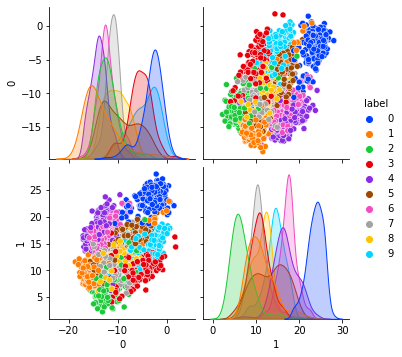

In [164]:
plot_encoding_2dim(ConvEncoder(bottleneck=2), params)

### BayesOpt for optimizing the latent dimension

In [171]:
pip install bayesian-optimization

Note: you may need to restart the kernel to use updated packages.


In [189]:
def black_box_function(x, y):
    """Function with unknown internals we wish to maximize.

    This is just serving as an example, for all intents and
    purposes think of the internals of this function, i.e.: the process
    which generates its output values, as unknown.
    """
    x = int(x)
    y = int(y)
    return function_discrete(x, y)

In [190]:
def function_discrete(x, y):
    return -x ** 2 - (y - 1) ** 2 + 1

In [191]:
from bayes_opt import BayesianOptimization


In [192]:
pbounds = {'x': (2, 4), 'y': (-3, 3)}


In [193]:
optimizer = BayesianOptimization(
    f=black_box_function,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

In [195]:
optimizer.maximize(
)

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
| 6         | -12.0     | 2.294     | -2.446    |
| 7         | -4.0      | 2.373     | -0.9266   |
| 8         | -4.0      | 2.794     | 0.2329    |
| 9         | -3.0      | 2.838     | 1.111     |
| 10        | -4.0      | 2.409     | 2.269     |
| 11        | -4.0      | 2.324     | 0.8022    |
| 12        | -4.0      | 2.766     | -0.4462   |
| 13        | -9.0      | 3.1       | 2.028     |
| 14        | -4.0      | 2.238     | -0.05102  |
| 15        | -3.0      | 2.049     | 1.708     |
| 16        | -3.0      | 2.0       | 1.243     |
| 17        | -4.0      | 2.297     | -0.5599   |
| 18        | -4.0      | 2.0       | 2.832     |
| 19        | -12.0     | 3.392     | -1.019    |
| 20        | -31.0     | 4.0       | -3.0      |
| 21        | -19.0     | 4.0       | 3.0       |
| 22        | -4.0      | 2.0       | 2.285     |
| 23        | -7.0      | 2.572     | 3.0       |


In [196]:
optimizer.max

{'target': -3.0, 'params': {'x': 2.8340440094051482, 'y': 1.3219469606529488}}

In [199]:
{k: int(v) for k, v in optimizer.max['params'].items()}

{'x': 2, 'y': 1}

In [202]:
function_discrete(2, 1)

-3

Let us keep a separate validation set

In [210]:
def loss_model(params, X, model):
    X_hat = model.apply(params, X)
    diff = X - X_hat
    return (diff**2).sum(axis=1).mean()/X.shape[1]
    

In [230]:
from functools import partial

e = partial(loss_model, model=cae)
e(params, X)

DeviceArray(21.412178, dtype=float32)

In [251]:
def validation_loss_discrete(bn):
    assert type(bn) == int
    
    # Train the model on bn sized bottleneck
    cae = ConvAE(bn)
    loss_fn_concrete = jax.jit(partial(loss_model, model=cae))
    loss_grad_fn = jax.value_and_grad(loss_fn_concrete)
    tx = optax.adam(learning_rate=1e-2)
    params = cae.init(random.PRNGKey(0), X_train)
    opt_state = tx.init(params)
    print(f"--------Bottleneck of Size: {bn}-------------")
    for i in range(30):
        loss_val, grads = loss_grad_fn(params, X_train)
        updates, opt_state = tx.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        
        if i % 5 == 0:
            print('Loss step {}: '.format(i), loss_val)
    print(f"--------End-------------")

    
    # Evaluate on validation dataset
    return loss_fn_concrete(params, X_validation)

    
    
    

In [252]:
X_train, X_validation = X[:1000], X[1000:]

In [253]:
validation_loss_discrete(2)

--------Bottleneck of Size: 2-------------
Loss step 0:  62.277145
Loss step 5:  58.503716
Loss step 10:  53.984253
Loss step 15:  49.513386
Loss step 20:  43.07832
Loss step 25:  38.30597
--------End-------------


DeviceArray(36.75615, dtype=float32)

In [254]:
def validation_loss_bb(bn):
    bn_int = int(bn)
    return -validation_loss_discrete(bn_int)

In [255]:
validation_loss_bb(2.5)

--------Bottleneck of Size: 2-------------
Loss step 0:  62.277145
Loss step 5:  58.503716
Loss step 10:  53.984253
Loss step 15:  49.513386
Loss step 20:  43.07832
Loss step 25:  38.30597
--------End-------------


DeviceArray(-36.75615, dtype=float32)

In [260]:
pbounds = {'bn': (1, 15)}
optimizer = BayesianOptimization(
    f=validation_loss_bb,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

In [262]:
optimizer.maximize(n_iter=8)

|   iter    |  target   |    bn     |
-------------------------------------
--------Bottleneck of Size: 2-------------
Loss step 0:  62.277145
Loss step 5:  58.503716
Loss step 10:  53.984253
Loss step 15:  49.513386
Loss step 20:  43.07832
Loss step 25:  38.30597
--------End-------------
| 10        | -36.76    | 2.293     |
--------Bottleneck of Size: 3-------------
Loss step 0:  65.48679
Loss step 5:  58.326893
Loss step 10:  49.75838
Loss step 15:  46.69208
Loss step 20:  42.674248
Loss step 25:  40.35544
--------End-------------
| 11        | -38.77    | 3.608     |
--------Bottleneck of Size: 5-------------
Loss step 0:  65.60659
Loss step 5:  58.475433
Loss step 10:  52.240562
Loss step 15:  43.224567
Loss step 20:  36.311962
Loss step 25:  31.103024
--------End-------------
| 12        | -30.86    | 5.838     |
--------Bottleneck of Size: 6-------------
Loss step 0:  61.45091
Loss step 5:  55.825485
Loss step 10:  47.88899
Loss step 15:  40.13176
Loss step 20:  37.625443
Loss s

In [263]:
optimizer.max

{'target': -30.859262466430664, 'params': {'bn': 5.232656016845757}}

### VAE

In [393]:
class VAE_Encoder(nn.Module):
    bottleneck: int
        
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(5)(x)
        x = nn.selu(x)
        mu = nn.Dense(features=self.bottleneck)(x)
        log_std = nn.Dense(features=self.bottleneck)(x)
        return mu, log_std

In [394]:
def reparameterize(mu, log_std, key=random.PRNGKey(0), samples=1):
    std = jnp.exp(log_std)
    eps = random.normal(key=key, shape=(samples,))
    return mu + eps*std

Text(0.5, 1.0, 'Mean:2.00, stddev: 1.00')

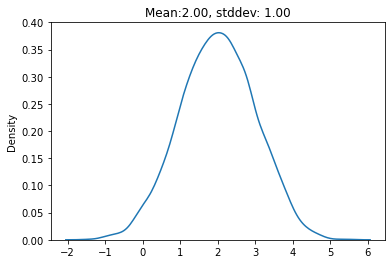

In [395]:
samples = reparameterize(2, jnp.log(1), samples=5000)
sns.kdeplot(samples)
plt.title(f"Mean:{jnp.mean(samples):0.2f}, stddev: {jnp.std(samples):0.2f}")

In [396]:
class VAE(nn.Module):
    bottleneck: int
    out: int
    def setup(self):
        # Alternative to @nn.compact -> explicitly define modules
        # Better for later when we want to access the encoder and decoder explicitly
        self.encoder = VAE_Encoder(bottleneck=self.bottleneck)
        self.decoder = Decoder(out=self.out)

    def __call__(self, x, rng=random.PRNGKey(0)):
        mu, log_std = self.encoder(x)
        z = reparameterize(mu, log_std, key = rng)
        x_hat = self.decoder(z)
        return x_hat, mu, log_std
    

In [397]:
vae = VAE(bottleneck=2, out = 64)

In [398]:
params = vae.init(random.PRNGKey(10), X)

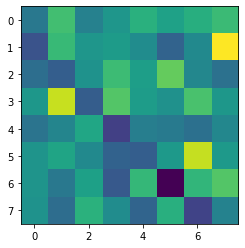

In [399]:
plt.imshow(vae.apply(params, X)[0][0].reshape(8, 8))

In [400]:
vae.apply(params, X, random.PRNGKey(10))[0][0].reshape(8, 8)

DeviceArray([[ -3999.3948  ,   6091.634   ,  -2634.2903  ,    307.4725  ,
                3932.0264  ,   1823.3337  ,   3852.1538  ,   5576.5547  ],
             [ -8809.295   ,   5299.905   ,    286.52243 ,   1059.392   ,
                -951.6251  ,  -6623.476   ,  -1463.6223  ,  16223.607   ],
             [ -5279.127   ,  -7333.8076  ,    -71.14889 ,   5679.2715  ,
                1384.2786  ,   8326.912   ,  -1747.9415  ,  -4802.3364  ],
             [   403.37354 ,  13455.674   ,  -7414.1875  ,   7299.7046  ,
                1180.7397  ,   -328.4939  ,   6619.129   ,    363.7464  ],
             [ -4376.347   ,  -2045.3044  ,   2618.4092  , -10890.392   ,
               -3035.3813  ,  -3574.749   ,  -5057.254   ,  -1859.8507  ],
             [   -53.99182 ,   2318.1067  ,  -1323.9073  ,  -6801.475   ,
               -7300.1484  ,    865.416   ,  13349.923   ,    865.3763  ],
             [    37.275234,  -3962.8315  ,   1771.9873  ,  -7992.711   ,
                4896.557   , -17

In [401]:
vae_e = VAE_Encoder(2)
mu, log_sigma = vae_e.apply({"params":params["params"]["encoder"]}, X)

In [402]:
tfd = tfp.distributions


In [403]:
q

<tfp.distributions.Normal 'Normal' batch_shape=[1797, 2] event_shape=[] dtype=float32>

In [404]:
tfd.kl_divergence(q, p).shape

(1797, 2)

In [405]:
tfd.kl_divergence(q, p).mean()

DeviceArray(3.618906e+16, dtype=float32)

In [406]:
q.stddev()

DeviceArray([[1.8886395e+03, 9.8628054e+00],
             [7.7281875e+04, 1.7193224e+02],
             [9.4159406e+04, 3.2940300e+01],
             ...,
             [4.5497965e+06, 7.3497736e+02],
             [2.0660315e+01, 1.4261727e+00],
             [2.0684541e+03, 9.5742807e+00]], dtype=float32)

### Loss




In [407]:
@jax.jit
def loss_vae(params, X, rng=random.PRNGKey(0)):
    X_hat, mu, log_sigma = vae.apply(params, X, rng)
    q = tfd.Normal(loc=mu, scale=jnp.exp(log_sigma))
    p = tfd.Normal(loc = 0., scale=1.)
    kl_loss = tfd.kl_divergence(q, p).mean()
    
    diff = X - X_hat
    recon_loss = (diff**2).sum(axis=1).mean()/X.shape[1]
    
    return recon_loss + 0.0020*kl_loss

In [408]:
loss_vae(params, X, random.PRNGKey(4))

DeviceArray(5.507718e+12, dtype=float32)

In [409]:
import optax
learning_rate = 0.01
tx = optax.adam(learning_rate=learning_rate)
opt_state = tx.init(params)
loss_grad_fn = jax.value_and_grad(loss_vae)

In [424]:
for i in range(2001):
    rng, key = random.split(rng)
    loss_val, grads = loss_grad_fn(params, X, rng)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 50 == 0:
        print('Loss step {}: '.format(i), loss_val)

Loss step 0:  36.85747
Loss step 50:  36.84325
Loss step 100:  36.26701
Loss step 150:  35.954502
Loss step 200:  38.242577
Loss step 250:  35.514988
Loss step 300:  35.33608
Loss step 350:  34.920235
Loss step 400:  34.450153
Loss step 450:  34.312443
Loss step 500:  33.862934
Loss step 550:  33.58998
Loss step 600:  33.400883
Loss step 650:  33.19834
Loss step 700:  33.01729
Loss step 750:  32.664143
Loss step 800:  32.12002
Loss step 850:  32.358864
Loss step 900:  31.658987
Loss step 950:  31.269337
Loss step 1000:  30.983906
Loss step 1050:  32.068443
Loss step 1100:  30.430012
Loss step 1150:  30.177364
Loss step 1200:  30.59898
Loss step 1250:  29.678045
Loss step 1300:  29.972729
Loss step 1350:  29.088001
Loss step 1400:  29.233213
Loss step 1450:  28.752787
Loss step 1500:  30.446037
Loss step 1550:  28.061802
Loss step 1600:  27.81452
Loss step 1650:  27.74373
Loss step 1700:  27.317266
Loss step 1750:  27.601862
Loss step 1800:  26.856634
Loss step 1850:  26.618937
Loss ste

In [418]:
X_recon, _, _ = vae.apply(params, X)

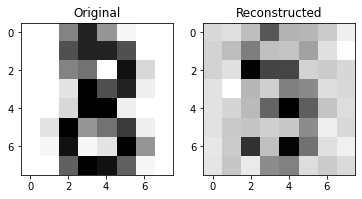

In [419]:
plot_orig_recon(8)

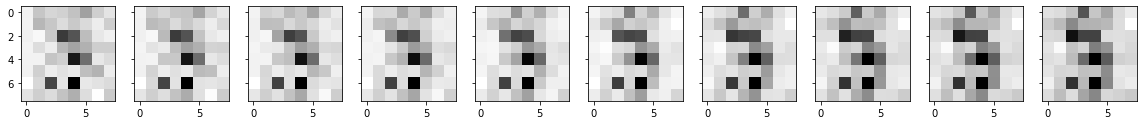

In [420]:
dec = Decoder(out=64)
N = 10
x_range = jnp.linspace(-2, 2, N)
fig, ax = plt.subplots(ncols=N, sharey=True, figsize=(20, 4))
for i in range(N):
    ax[i].imshow(dec.apply({"params":params["params"]["decoder"]}, jnp.array([x_range[i], 0.0])).reshape(8, 8), cmap='Greys')

In [421]:
def plot_encoding_2dim_vae(encoder, params):
    assert encoder.bottleneck >= 2
    mu, log_sigma = encoder.apply({"params":params["params"]["encoder"]}, X)
    df = pd.DataFrame(mu)
    df["label"] = y
    sns.pairplot(df, hue="label", palette="bright")

In [422]:
vae_enc = VAE_Encoder(2)
mu, log_sigma = vae_enc.apply({"params":params["params"]["encoder"]}, X)
#plot_encoding_2dim_vae(VAE_Encoder(2), params)

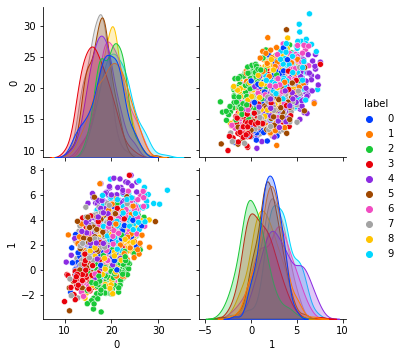

In [423]:
plot_encoding_2dim_vae(vae_enc, params)

### TODO

- regular AE: Bayesopt for latent dimension
- generation from regular AE
- graph of reconstruction loss v/s latent dimension for regular AE
- GIF for walking in latent space for VAE
- Reconstruction as a factor of Recon + Beta X KL
- Get the Encoder from AE object directly
- Impact of MC samples
- Reconstruction v/s Expected Log Likelihood (confirm the trend is same for both)
- Cleanup code so that can be reused rather than copy pasting
- Sparse VAE
- Add references
- Add bib entry
- Consider CNNs for more realistic datasets

1. https://lilianweng.github.io/posts/2018-08-12-vae/
2. https://theaisummer.com/jax-tensorflow-pytorch/
3. https://dmol.pub/dl/VAE.html